In [21]:
import importlib
import micasense.imageset
import micasense.capture
import micasense.imageset as imageset
import micasense.capture as capture
import micasense.imageutils as imageutils
import micasense.plotutils as plotutils

import cv2
import os, glob
import json
import pickle #This library will maintain the format as well
from osgeo import gdal,osr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL.Image as Image
import exiftool
import datetime
from math import ceil
from tqdm import tqdm
import re
import glob
import contextlib
from PIL import Image

import algorithms.mutils as mutils
import algorithms.radiometric_calib_utils as rcu
import algorithms.extract_spectral as espect
import algorithms.flight_attributes
import algorithms.validate_algorithm

importlib.reload(algorithms.validate_algorithm)
importlib.reload(algorithms.flight_attributes)

import algorithms.flight_attributes as FlightAttributes
import algorithms.validate_algorithm as ValidateAlgo

# Import all folder

In [22]:
rootDir = r"D:\EPMC_flight\pandanRes"
dirsList = [os.path.join(rootDir,f) for f in sorted(os.listdir(rootDir)) if f.endswith("overlap")]
rawImgDirs = [os.path.join(dirs,f) for dirs in dirsList for f in os.listdir(dirs) if f == "RawImg"]

# list all panel imges corresponding to the folder
panelImges = [0,0,0,0,0,55,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0]

assert len(panelImges) == len(rawImgDirs), "every directory must have one QR image"
folderPanelDir = []
for folderName, imgIdx in zip(rawImgDirs,panelImges):
    # folderPanelDir[folderName] = imgIdx
    folderPanelDir.append({'folderName': folderName, 'panelIndex': imgIdx})

folderPanelDir[0]

{'folderName': 'D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap\\RawImg',
 'panelIndex': 0}

In [23]:
selectedIdx = 0

## Import saved band_aligned images

In [24]:
imagePath =  folderPanelDir[selectedIdx]['folderName'] #r"D:\EPMC_flight\pandanResTest\F1\RawImg"
if os.path.exists(os.path.join(os.path.dirname(imagePath),'thumbnails')):
    parent_dir = os.path.join(os.path.dirname(imagePath),'thumbnails')
    fp_list = [os.path.join(parent_dir,fp) for fp in sorted(os.listdir(parent_dir))]

else:
    fp_list = None

fp_list

['D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap\\thumbnails\\IMG_0000_1.jpg',
 'D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap\\thumbnails\\IMG_0001_1.jpg',
 'D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap\\thumbnails\\IMG_0002_1.jpg',
 'D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap\\thumbnails\\IMG_0003_1.jpg',
 'D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap\\thumbnails\\IMG_0004_1.jpg',
 'D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap\\thumbnails\\IMG_0005_1.jpg',
 'D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap\\thumbnails\\IMG_0006_1.jpg',
 'D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap\\thumbnails\\IMG_0007_1.jpg',
 'D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap\\thumbnails\\IMG_0008_1.jpg',
 'D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap\\thumbnails\\IMG_0009_1.jpg',
 'D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap\\thumbnails\\IMG_0010_1.jpg',
 'D:\\EPMC_flight\\pandanRes\\00angle_15H_50overlap\\thumbnails\\IMG_0011_1.jpg',
 'D:\\EPMC_fligh

## Import flight attributes data

In [25]:
if os.path.exists(os.path.join(os.path.dirname(imagePath),'flight_attributes')):
    parent_dir = os.path.join(os.path.dirname(imagePath),'flight_attributes')
    flight_attributes_df = os.path.join(parent_dir,'flight_attributes.csv')
    flight_attributes_df = pd.read_csv(flight_attributes_df)
else:
    flight_attributes_df = None

flight_attributes_df

,timestamp,latitude,longitude,altitude,image_name,capture_id,dls-yaw,dls-pitch,dls-roll,irr-475,irr-560,irr-668,irr-842,irr-717,irr-444,irr-531,irr-650,irr-705,irr-740
0,2023-09-20 02:37:46.734108+00:00,1.318984,103.736576,30.643,IMG_0000_1.tif,iRMg5hgGW1CUYi1x0TlZ,0.635662,-0.207969,-0.047398,0.744841,0.663156,0.547643,0.342493,0.428046,0.670643,0.687768,0.544391,0.483355,0.445280
1,2023-09-20 02:38:25.652070+00:00,1.318969,103.736552,31.828,IMG_0001_1.tif,ws9iE0ctR0GdjP9XYeKY,1.768777,-0.081365,-0.034487,1.422521,1.305924,1.134642,0.701718,0.873402,1.247496,1.338475,1.114349,0.995491,0.917994
2,2023-09-20 02:40:02.646889+00:00,1.318935,103.736667,31.825,IMG_0002_1.tif,o34Xx90IfaznKeSuG8Bq,1.807706,-0.066323,-0.019898,0.403826,0.350253,0.274099,0.171907,0.214341,0.371606,0.366940,0.274736,0.241525,0.222003
3,2023-09-20 02:40:27.129650+00:00,1.318957,103.736711,43.093,IMG_0003_1.tif,9uaW8y0N0EE0vgF9zbKj,0.603067,-0.147849,0.018589,0.394172,0.341704,0.268347,0.168132,0.209751,0.362208,0.357995,0.268675,0.236576,0.217652
4,2023-09-20 02:40:28.687747+00:00,1.318989,103.736740,43.126,IMG_0004_1.tif,573tCs56BPBA8nQJo06y,0.632837,-0.131004,0.014908,0.393962,0.341402,0.268274,0.168016,0.209701,0.361889,0.357701,0.268546,0.236570,0.217697
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,2023-09-20 02:42:37.754046+00:00,1.318995,103.736652,52.113,IMG_0077_1.tif,LxWxxE0dKGSKCJPD9emk,-1.710094,-0.109079,-0.110542,0.324510,0.278215,0.215442,0.135719,0.169883,0.300243,0.292801,0.216655,0.190829,0.175554
78,2023-09-20 02:42:40.221641+00:00,1.318985,103.736609,52.254,IMG_0078_1.tif,vOZMfLXGQb0fb52EGfk8,-1.701558,-0.107945,-0.112222,0.322847,0.276751,0.214274,0.134965,0.168932,0.298718,0.291270,0.215472,0.189780,0.174602
79,2023-09-20 02:42:42.735583+00:00,1.318975,103.736563,52.359,IMG_0079_1.tif,o4SQ3aYYcZEyDzjKdJhi,-1.701601,0.009124,-0.105172,0.321727,0.275801,0.213584,0.134510,0.168352,0.297657,0.290258,0.214756,0.189152,0.174039
80,2023-09-20 02:44:00.101050+00:00,1.318983,103.736560,24.732,IMG_0080_1.tif,cbN2MVydgBF9ySm3oP9I,0.578686,-0.115606,-0.048260,0.322058,0.274594,0.213920,0.134003,0.168978,0.296372,0.289454,0.214553,0.190291,0.175322


## View flight altitude

In [26]:
# helper function that is only relevant to my file naming
def get_heights():
    measuredHeight = np.median(flight_attributes_df['altitude'])
    # where the folder name contains the flight height information e.g. ...15H...25H...
    actualHeight = int(re.search('[0-9][0-9]H',os.path.dirname(imagePath)).group(0).replace('H',''))
    DEM_offset_height = int(measuredHeight - actualHeight)
    print(f'offset height: {DEM_offset_height}m')
    return {'measuredHeight':measuredHeight, 
    'actualHeight':actualHeight, 
    'height_max':np.max(flight_attributes_df['altitude'].values),
    'height_min':np.min(flight_attributes_df['altitude'].values),
    'DEM_offset_height':DEM_offset_height}

height_dict = get_heights()

offset height: 26m


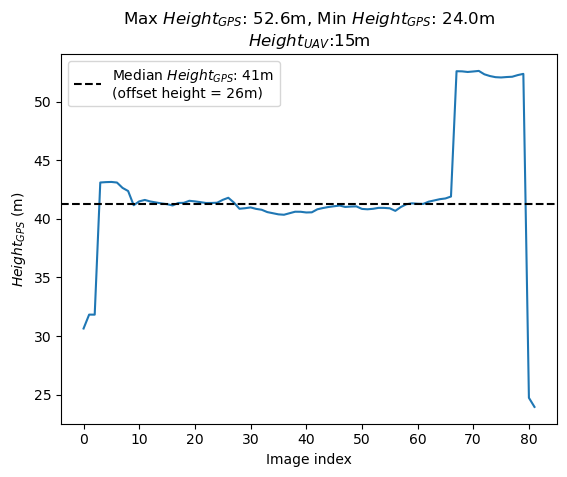

In [27]:
plt.figure()
plt.plot(flight_attributes_df.index.to_list(),flight_attributes_df['altitude'])
height_max = height_dict['height_max']
height_min = height_dict['height_min']
measuredHeight = height_dict['measuredHeight']
actualHeight = height_dict['actualHeight']
DEM_offset_height = height_dict['DEM_offset_height']
plt.axhline(y=measuredHeight, ls='--',c='k',label=r'Median $Height_{GPS}$:' f" {int(measuredHeight)}m\n(offset height = {DEM_offset_height}m)")
plt.title(r'Max $Height_{GPS}$:' + f' {height_max:.1f}m, ' + r'Min $Height_{GPS}$: ' + f'{height_min:.1f}m\n' + r'$Height_{UAV}$:' +f'{actualHeight}m')
plt.ylabel(r'$Height_{GPS}$ (m)')
plt.xlabel('Image index')
plt.legend()
# save fig
parentDir = os.path.join(os.path.dirname(imagePath),"images")
os.mkdir(parentDir) if not os.path.exists(parentDir) else None
fname = os.path.join(parentDir,f'height_timeseries.png')
plt.savefig(fname)

plt.show()

## Detect points/Import GPS points

In [28]:
def readSelectedGPS(imagePath):
    fp = os.path.join(os.path.dirname(imagePath),'flight_attributes','gps_index.txt')
    with open(fp, "r") as output:
        idx_list = output.readlines()
    intList = sorted([int(i.replace('\n','')) for i in idx_list])
    print(intList)
    assert len(intList)%2 == 0
    n = len(intList)//2
    listIndex = [np.arange(intList[i*2],intList[i*2+1]+1).tolist() for i in range(n)]
    return [i for l in listIndex for i in l]
ls_idx = readSelectedGPS(imagePath)

[10, 15, 19, 25, 29, 35, 39, 45, 49, 55, 59, 65]


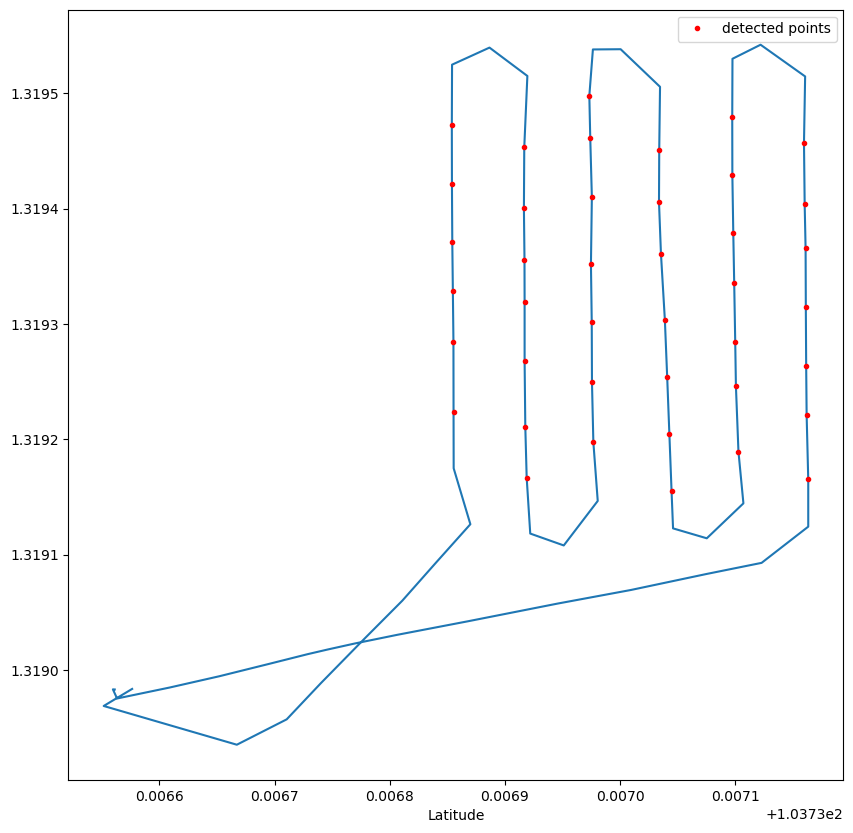

[10, 11, 12, 13, 14, 15, 19, 20, 21, 22, 23, 24, 25, 29, 30, 31, 32, 33, 34, 35, 39, 40, 41, 42, 43, 44, 45, 49, 50, 51, 52, 53, 54, 55, 59, 60, 61, 62, 63, 64, 65]


In [29]:
DL = FlightAttributes.DetectLines(flight_attributes_df, n = 3, thresh=0.99, plot=True)
flight_points=flight_attributes_df.iloc[ls_idx,1:3].reset_index().rename(columns={"latitude":'lat','longitude':'lon'}).to_dict('records')

flight_points = DL.get_points(flight_points = ls_idx)

print(flight_points)

# No correction

c:\Users\PAKHUIYING\anaconda3\envs\micasense_clone\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


shape of canvas(4156, 4189, 3)


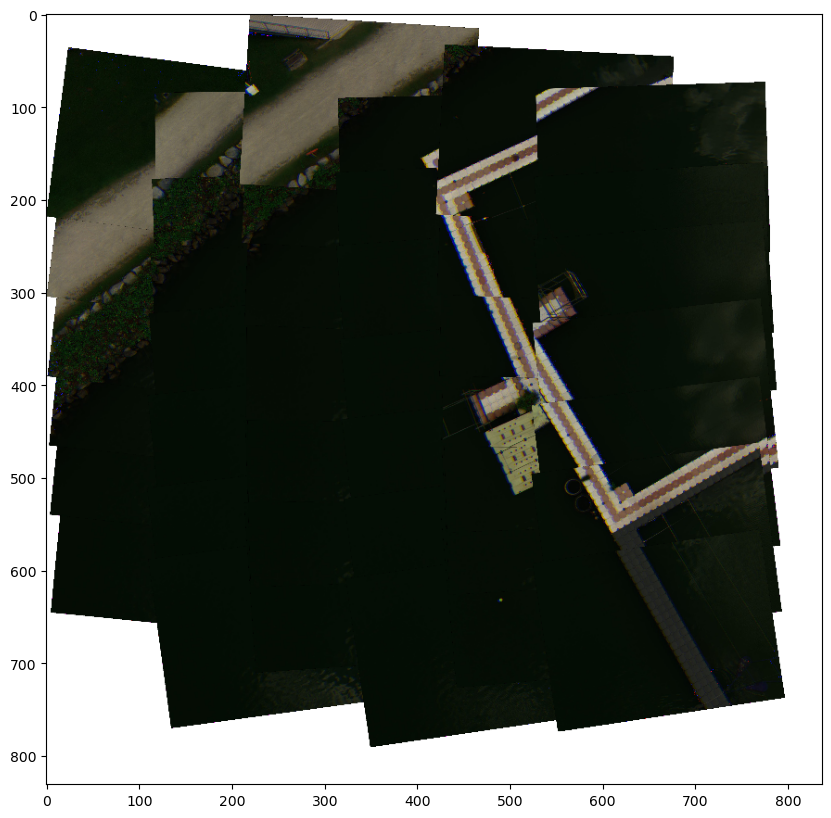

In [37]:
DEM_offset_height = 21
df_cropped = flight_attributes_df.iloc[flight_points,:]
df_cropped['flight_angle'] = -df_cropped.loc[:,'dls-yaw']/np.pi*180
PG = FlightAttributes.PlotGeoreference(df_cropped,fp_list,DEM_offset_height = DEM_offset_height)
im_display = PG.plot_georeference(reduction_factor=5,plot=True)

# Interpolate flight
Interpolate coordinates

In [10]:
IC = FlightAttributes.InterpolateCoordinates(flight_attributes_df)
interp_dist_dict = IC.get_interpolated_dict()
# shift_n: if positive, interpolate forward, if negative, interpolate backwards
df_interpolated = IC.shift_coord(interp_dist_dict, shift_n=9)
df_interpolated.head(10)

,timestamp,latitude,longitude,altitude,image_name,capture_id,dls-yaw,dls-pitch,dls-roll,irr-475,irr-560,irr-668,irr-842,irr-717,irr-444,irr-531,irr-650,irr-705,irr-740,flight_angle
0,2023-09-20 02:37:46.734108+00:00,1.318965,103.736566,30.643,IMG_0000_1.tif,iRMg5hgGW1CUYi1x0TlZ,0.635662,-0.207969,-0.047398,0.744841,0.663156,0.547643,0.342493,0.428046,0.670643,0.687768,0.544391,0.483355,0.445280,-36.420749
1,2023-09-20 02:38:25.652070+00:00,1.318957,103.736594,31.828,IMG_0001_1.tif,ws9iE0ctR0GdjP9XYeKY,1.768777,-0.081365,-0.034487,1.422521,1.305924,1.134642,0.701718,0.873402,1.247496,1.338475,1.114349,0.995491,0.917994,-101.343431
2,2023-09-20 02:40:02.646889+00:00,1.318955,103.736706,31.825,IMG_0002_1.tif,o34Xx90IfaznKeSuG8Bq,1.807706,-0.066323,-0.019898,0.403826,0.350253,0.274099,0.171907,0.214341,0.371606,0.366940,0.274736,0.241525,0.222003,-103.573932
3,2023-09-20 02:40:27.129650+00:00,1.318989,103.736741,43.093,IMG_0003_1.tif,9uaW8y0N0EE0vgF9zbKj,0.603067,-0.147849,0.018589,0.394172,0.341704,0.268347,0.168132,0.209751,0.362208,0.357995,0.268675,0.236576,0.217652,-34.553166
4,2023-09-20 02:40:28.687747+00:00,1.319020,103.736771,43.126,IMG_0004_1.tif,573tCs56BPBA8nQJo06y,0.632837,-0.131004,0.014908,0.393962,0.341402,0.268274,0.168016,0.209701,0.361889,0.357701,0.268546,0.236570,0.217697,-36.258909
5,2023-09-20 02:40:30.330859+00:00,1.319058,103.736809,43.141,IMG_0005_1.tif,I2juk34Nr71Sfkzl2aem,0.651756,-0.067880,0.002542,0.393764,0.341155,0.268135,0.167898,0.209601,0.361655,0.357463,0.268384,0.236479,0.217638,-37.342865
6,2023-09-20 02:40:31.269048+00:00,1.319093,103.736840,43.090,IMG_0006_1.tif,9EaJCkN0vYf6zeBW7jnD,0.667226,-0.084777,-0.001700,0.393767,0.341109,0.268157,0.167891,0.209619,0.361614,0.357426,0.268384,0.236518,0.217694,-38.229255
7,2023-09-20 02:40:32.471750+00:00,1.319125,103.736869,42.634,IMG_0007_1.tif,yu4U5rnpn2v8Q9i1K7YV,0.683263,-0.094040,0.001040,0.393767,0.341074,0.268163,0.167897,0.209650,0.361600,0.357399,0.268388,0.236549,0.217736,-39.148097
8,2023-09-20 02:40:33.976485+00:00,1.319168,103.736857,42.369,IMG_0008_1.tif,prAeU4Hl1OsuImGBsT4v,0.700973,0.198182,-0.013030,0.393597,0.340689,0.266982,0.167425,0.209068,0.362015,0.357160,0.267529,0.235607,0.216732,-40.162781
9,2023-09-20 02:40:45.499936+00:00,1.319219,103.736855,41.155,IMG_0009_1.tif,5TPdIJ1a3X9wKk11ZjAm,0.094337,-0.107877,-0.006992,0.390033,0.336992,0.264552,0.165879,0.207496,0.358496,0.353475,0.265035,0.233819,0.215275,-5.405104


shape of canvas(4156, 4189, 3)
shape of canvas(4242, 4189, 3)
shape of canvas(4329, 4189, 3)
shape of canvas(4415, 4188, 3)
shape of canvas(4502, 4186, 3)
shape of canvas(4588, 4186, 3)
shape of canvas(4675, 4186, 3)
shape of canvas(4752, 4186, 3)


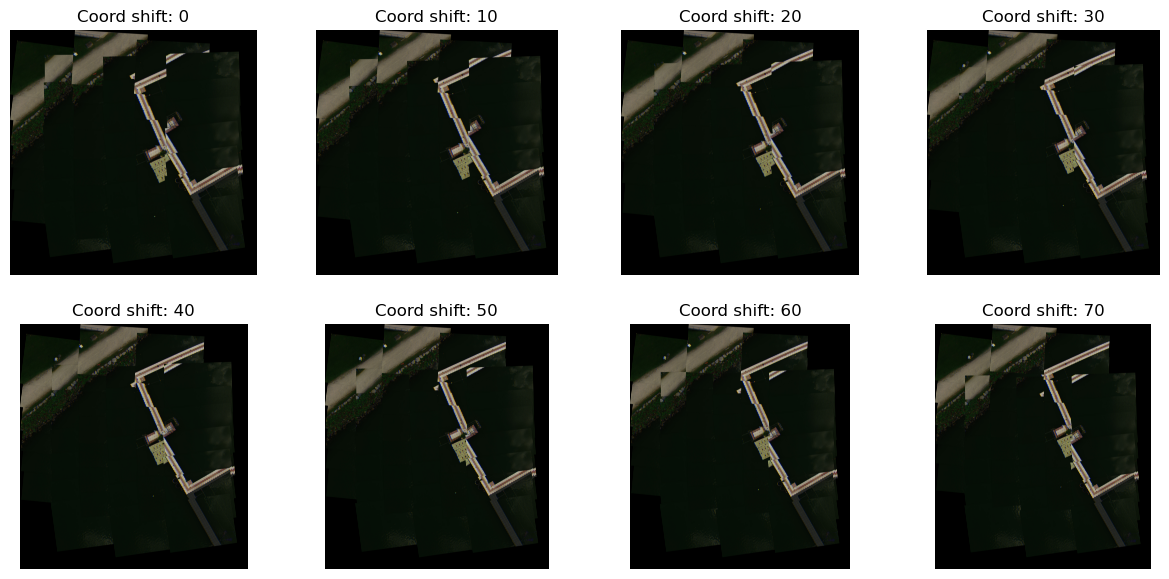

In [49]:
interpolate_distance = 0.01
pad_distance = 1.5
estimate_angle="yaw"
dist1 = 0
dist2 = 70
DEM_offset_height = 21

IC = FlightAttributes.InterpolateCoordinates(flight_attributes_df, 
                            interpolate_distance=interpolate_distance, 
                            pad_distance=pad_distance,
                            estimate_angle=estimate_angle)
interp_dist_dict = IC.get_interpolated_dict()

n_fig = 8
fig, axes = plt.subplots(2,ceil(n_fig/2), figsize=(15,7))

dist_shift = int(pad_distance/interpolate_distance) - 1 # minus one so that we dont get indexing error

# for i, (shift_n,ax) in enumerate(zip(np.linspace(-dist_shift,dist_shift,n_fig,dtype=int),axes.flatten())):
for i, (shift_n,ax) in enumerate(zip(np.linspace(dist1,dist2,n_fig,dtype=int),axes.flatten())):
    df_interpolated = IC.shift_coord(interp_dist_dict, shift_n=shift_n)
    df_cropped = df_interpolated.iloc[flight_points,:]
    PG = FlightAttributes.PlotGeoreference(df_cropped,fp_list,DEM_offset_height = DEM_offset_height)
    im_display = PG.plot_georeference(reduction_factor=5,plot=False)
    ax.imshow(im_display)
    ax.axis('off')
    ax.set_title(f'Coord shift: {shift_n}')
# plt.suptitle(f'estimate angle: {estimate_angle}')
plt.show()

# Interpolate Flight
Time delay correction

In [ ]:
imagePath = folderPanelDir[selectedIdx]['folderName']
estimate_angle="yaw"
# import flight attributes df
if os.path.exists(os.path.join(os.path.dirname(imagePath),'flight_attributes')):
    parent_dir = os.path.join(os.path.dirname(imagePath),'flight_attributes')
    flight_attributes_df = os.path.join(parent_dir,'flight_attributes.csv')
    flight_attributes_df = pd.read_csv(flight_attributes_df)
else:
    flight_attributes_df = None

IF = FlightAttributes.InterpolateFlight(flight_attributes_df, 
                                        interpolate_milliseconds=100, 
                                        estimate_angle = estimate_angle)
df_interpolated = IF.interpolate_flight()
df_interpolated.head()

82it [00:00, 1732.73it/s]


rows shifted: -20
shape of canvas(4891, 4179, 3)
rows shifted: -17
shape of canvas(4878, 4181, 3)
rows shifted: -14
shape of canvas(4810, 4182, 3)
rows shifted: -11
shape of canvas(4732, 4181, 3)
rows shifted: -8
shape of canvas(4654, 4181, 3)
rows shifted: -5
shape of canvas(4444, 4188, 3)
rows shifted: -2
shape of canvas(4241, 4189, 3)
rows shifted: 0
shape of canvas(4156, 4189, 3)


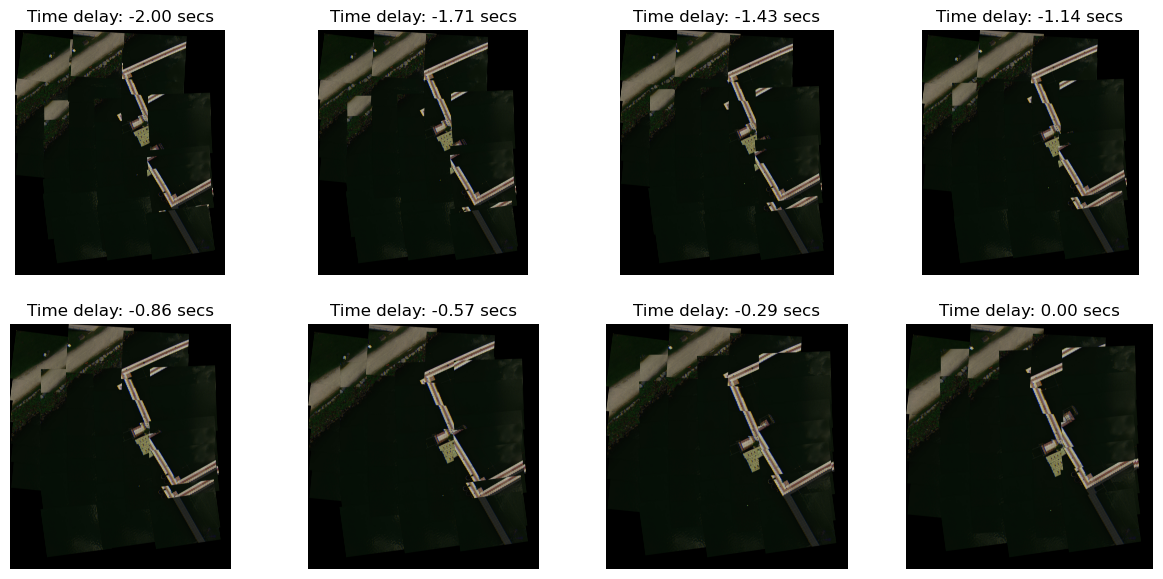

In [63]:
# estimate the bounds of time delay correction
est_time_delay1 = 0
est_time_delay2 = -2

# indicate what method to estimate flight_angle in `estimate_angle`: "yaw" or "coord"
estimate_angle = "yaw"
# because imaging may not be conducted at MSL, water body may be located a few meters above MSL. Use minimum height recorded in the GPS module to estimate the altitude of the water body
DEM_offset_height = 21
IF = FlightAttributes.InterpolateFlight(flight_attributes_df, 
                                        interpolate_milliseconds=100, 
                                        estimate_angle = estimate_angle)
df_interpolated = IF.interpolate_flight(plot=False)

n_fig = 8
fig, axes = plt.subplots(2,4, figsize=(15,7))

for i, (td,ax) in enumerate(zip(np.linspace(est_time_delay2,est_time_delay1, n_fig),axes.flatten())):
    df1 = FlightAttributes.time_delta_correction(df_interpolated, timedelta=td, 
                                                 columns_to_shift = ['timestamp', 'timedelta', 'latitude', 'longitude'])
    df_cropped = df1.iloc[flight_points,:]
    PG = FlightAttributes.PlotGeoreference(df_cropped,fp_list,DEM_offset_height = DEM_offset_height)
    im_display = PG.plot_georeference(reduction_factor=5,plot=False)
    ax.imshow(im_display)
    ax.axis('off')
    ax.set_title(f'Time delay: {td:.2f} secs')
plt.show()

In [64]:
df_cropped

,image_name,timestamp,timedelta,latitude,longitude,altitude,flight_angle,north_vec,east_vec,capture_id,...,irr-560,irr-668,irr-842,irr-717,irr-444,irr-531,irr-650,irr-705,irr-740,index
10,IMG_0010_1.tif,2023-09-20 02:40:46.867245+00:00,180.133137,1.319223,103.736855,41.484,-5.633421,1.0,-1.0,TGMjtoMK4lZZHwz0gWE2,...,0.336241,0.263961,0.165486,0.207043,0.357777,0.352711,0.264435,0.233321,0.214836,10
11,IMG_0011_1.tif,2023-09-20 02:40:48.333197+00:00,181.599089,1.319285,103.736855,41.606,-6.052807,1.0,-1.0,Vbmk53xTHky4YeQ3tY5q,...,0.335740,0.263521,0.165222,0.206712,0.357304,0.352196,0.264010,0.232936,0.214483,11
12,IMG_0012_1.tif,2023-09-20 02:40:49.529728+00:00,182.795620,1.319329,103.736855,41.475,-6.219740,1.0,-1.0,sHfimxse9xw3yckAG5jT,...,0.335334,0.263198,0.165027,0.206479,0.356898,0.351778,0.263695,0.232662,0.214233,12
13,IMG_0013_1.tif,2023-09-20 02:40:50.856883+00:00,184.122775,1.319371,103.736854,41.391,-6.881566,1.0,-1.0,JTvwKvY3Wp1QRFABs177,...,0.334802,0.262754,0.164750,0.206159,0.356389,0.351234,0.263266,0.232289,0.213892,13
14,IMG_0014_1.tif,2023-09-20 02:40:52.169954+00:00,185.435846,1.319422,103.736854,41.308,-7.156555,1.0,-1.0,GSCS3gkaTUELPKSWJdea,...,0.334354,0.262390,0.164522,0.205883,0.355956,0.350776,0.262902,0.231979,0.213612,14
15,IMG_0015_1.tif,2023-09-20 02:40:53.589501+00:00,186.855393,1.319472,103.736854,41.245,-7.428374,1.0,1.0,a9W6IeTeApFvdy6YZmoD,...,0.333877,0.262015,0.164282,0.205592,0.355474,0.350284,0.262523,0.231655,0.213320,15
19,IMG_0019_1.tif,2023-09-20 02:41:02.187689+00:00,195.453581,1.319453,103.736917,41.534,-179.614441,-1.0,-1.0,JMwCyxZYTwIaNl8s1JqS,...,0.332671,0.260078,0.163659,0.204055,0.353862,0.348756,0.261007,0.229503,0.210897,19
20,IMG_0020_1.tif,2023-09-20 02:41:03.520863+00:00,196.786755,1.319400,103.736917,41.484,-178.043845,-1.0,1.0,rvW1ZR6L15nzlWYzQv47,...,0.331665,0.259325,0.163180,0.203390,0.352640,0.347652,0.260238,0.228773,0.210203,20
21,IMG_0021_1.tif,2023-09-20 02:41:04.723871+00:00,197.989763,1.319355,103.736917,41.416,-176.402280,-1.0,1.0,9QsYgvMByLtvzwrE8a76,...,0.330739,0.258621,0.162748,0.202787,0.351560,0.346650,0.259524,0.228103,0.209575,21
22,IMG_0022_1.tif,2023-09-20 02:41:05.909510+00:00,199.175402,1.319319,103.736917,41.346,-175.186342,-1.0,1.0,k69jmBnbJCmeLakHMOcd,...,0.329648,0.257777,0.162212,0.202077,0.350332,0.345482,0.258667,0.227319,0.208846,22


In [65]:
def BatchGeoreference(imagePath, df_cropped,DEM_offset_height,estimate_angle = "yaw"):
    # specify directory to save georeferenced images in
    georeferenced_thumbnails_directory = os.path.join(os.path.dirname(imagePath),f'corrected_{estimate_angle}_georeferenced_thumbnails')
    if not os.path.exists(georeferenced_thumbnails_directory):
        os.mkdir(georeferenced_thumbnails_directory)

    # check if rgb images are available
    thumbnails_directory = os.path.join(os.path.dirname(imagePath),'thumbnails')
    if os.path.exists(thumbnails_directory):
        fp_list = [os.path.join(thumbnails_directory,fp) for fp in sorted(os.listdir(thumbnails_directory))]

    else:
        fp_list = None

    # perform time delay correction
    column_idx = [i for i,c in enumerate(df_cropped.columns.to_list()) if c in ['latitude','longitude','altitude','flight_angle']]
    for i,rows in tqdm(df_cropped.iterrows()):
        if (i == 0) or (i > df_cropped.index[-1]):
            pass
        else:
            image_name = os.path.splitext(rows['image_name'])[0]
            lat,lon,altitude,flight_angle = rows[column_idx].tolist()
            # open image
            im = np.asarray(Image.open(fp_list[i])) if image_name in fp_list[i] else None
            if im is None:
                print(f"Image not found: {image_name}, {fp_list[i]}")
                pass
            else:
                image_fn = os.path.join(georeferenced_thumbnails_directory,image_name)
                GI = FlightAttributes.GeotransformImage(im,lat,lon,
                                            altitude = altitude - DEM_offset_height,
                                            angle = flight_angle)
                GI.georegister(image_fn)